# Section 1

Generating our data: a small dataset with in-distribution (IND) datapoints and a clearly separated out-of-distribution (OOD) cluster that we will use to test our models performance on unseen data.


In [5]:
# imports and set-up

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
# import seaborn as sns

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (6.2, 5.2)
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

rng = np.random.RandomState(42)

# 2. generate our IND data - two interlocking half circles (moons)
X_all, y_all = make_moons(n_samples=600, noise=0.2, random_state=rng)

X_train, X_ind_test, y_train, y_ind_test = train_test_split(
    X_all, y_all, test_size=0.3, random_state=rng, stratify=y_all
)

# 3. generate OOD data - separate gaussian cluster
X_ood = rng.normal(loc=[3.4, 3.0], scale=[0.35, 0.35], size=(120, 2))

# 4. print shape summary
print("Shapes: ",
        "Train:", X_train.shape,
        "IND test:", X_ind_test.shape,
        "OOD test:", X_ood.shape
)

Shapes:  Train: (420, 2) IND test: (180, 2) OOD test: (120, 2)


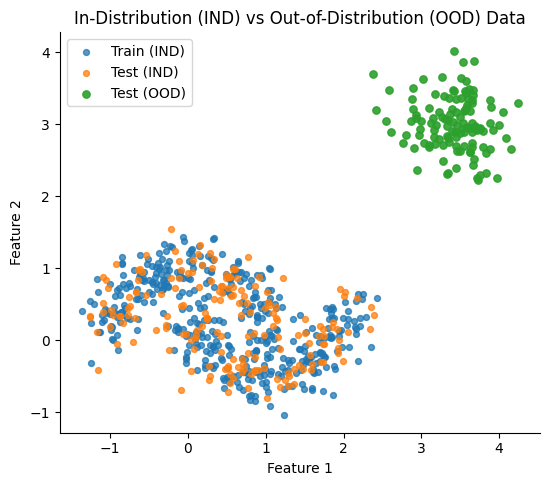

In [6]:
X_train_plot = X_train
X_test_plot = X_ind_test

fig, ax = plt.subplots()

ax.scatter(X_train_plot[:, 0], X_train_plot[:, 1], s=18, label='Train (IND)', alpha=0.75)
ax.scatter(X_test_plot[:, 0], X_test_plot[:, 1], s=18, label='Test (IND)', alpha=0.75)
ax.scatter(X_ood[:, 0], X_ood[:, 1], s=28, label='Test (OOD)', alpha=0.9)

ax.set_title("In-Distribution (IND) vs Out-of-Distribution (OOD) Data")
ax.set_xlabel("Feature 1")
ax.set_ylabel("Feature 2")
ax.legend()
plt.show()

In [10]:
import os, joblib

os.makedirs("artifacts", exist_ok=True)

#save arrays
np.save("artifacts/X_train.npy", X_train)
np.save("artifacts/y_train.npy", y_train)
np.save("artifacts/X_ind_test.npy", X_ind_test)
np.save("artifacts/y_ind_test.npy", y_ind_test)
np.save("artifacts/X_ood.npy", X_ood)

# save as a csv for easy viewing and also for streamlit demos
pd.DataFrame(np.c_[X_train, y_train], columns=["x1", "x2", "y"]).to_csv("artifacts/train_data.csv", index=False)
pd.DataFrame(np.c_[X_ind_test, y_ind_test], columns=["x1", "x2", "y"]).to_csv("artifacts/test_ind_data.csv", index=False)
pd.DataFrame(X_ood, columns=["x1", "x2"]).to_csv("artifacts/ood_data.csv", index=False)

print("Saved data to artifacts/ folder")

Saved data to artifacts/ folder


In [11]:
def describe(name, X):
    m = X.mean(axis=0)
    s = X.std(axis=0)
    print(f"{name:>10s} | mean: {m[0]:.3f}, {m[1]:.3f} | std: {s[0]:.3f}, {s[1]:.3f}")

describe("Train", X_train)
describe("IND Test", X_ind_test)
describe("OOD Test", X_ood)

     Train | mean: 0.506, 0.270 | std: 0.904, 0.545
  IND Test | mean: 0.504, 0.267 | std: 0.883, 0.526
  OOD Test | mean: 3.420, 3.005 | std: 0.358, 0.368


# Section 2

Build a baseline classifier (logistic regression) and see why its overconfident on OOD.

Logistic regression:
- computes a linear score (describes how likely it is for a datapoint to fit into a class)
- pass it through a **sigmoid** function - an S-shaped curve
- the sigmoid "translates" our score into a probability
- if the score is very positive or very negative, the sigmoid satures near 1 or 0 -- i.e. high confidence

-> objective: notice that our model will have high confidence even on data thats far from the training distribution

**WARNING:** overconfidence on unfamiliar inputs

In [13]:
from pathlib import Path

ART = Path("artifacts")
rng = np.random.RandomState(42)

def load_data():
    if (ART / "X_train.npy").exists():
        X_train = np.load(ART / "X_train.npy")
        y_train = np.load(ART / "y_train.npy")
        X_ind_test = np.load(ART / "X_ind_test.npy")
        y_ind_test = np.load(ART / "y_ind_test.npy")
        X_ood = np.load(ART / "X_ood.npy")
        print("Loaded data from artifacts/")
    else:
        raise FileNotFoundError("Data not found. Please run detection.ipynb to generate data.")
    return X_train, y_train, X_ind_test, y_ind_test, X_ood

X_train, y_train, X_ind_test, y_ind_test, X_ood = load_data()
print("Shapes: ",
        "Train:", X_train.shape,
        "IND test:", X_ind_test.shape,
        "OOD test:", X_ood.shape
)

Loaded data from artifacts/
Shapes:  Train: (420, 2) IND test: (180, 2) OOD test: (120, 2)


In [15]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(
    StandardScaler(), # puts our features on comparable scales
    LogisticRegression(random_state=rng) # logistic regression model
)
clf.fit(X_train, y_train)
print("Trained model.")

Trained model.
